In [2]:
import numpy as np
import matplotlib.pyplot as plt

N=2
H=3
T=20

dh = np.ones((N, H)) #dh初期化
print(dh)
np.random.seed(3)
Wh = np.random.randn(H, H) #重み初期化
print(Wh.T) 

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T) #dhとWhの転置をかける
  norm = np.sqrt(np.sum(dh**2))/ N #L2ノルム
  norm_list.append(norm)

[[1. 1. 1.]
 [1. 1. 1.]]
[[ 1.78862847 -1.8634927  -0.08274148]
 [ 0.43650985 -0.2773882  -0.62700068]
 [ 0.09649747 -0.35475898 -0.04381817]]


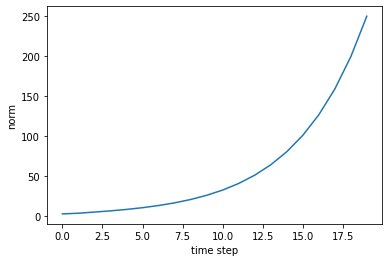

In [3]:
x = np.arange(len(norm_list))
plt.plot(x, norm_list, label='test')
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配が指数的に増加していることが確認できる。

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N=2
H=3
T=20

dh = np.ones((N, H)) #dh初期化
print(dh)
np.random.seed(3)
Wh = np.random.randn(H, H)*0.5 #重み初期化
print(Wh.T) 

norm_list = []
for t in range(T):
  dh = np.dot(dh, Wh.T) #dhとWhの転置をかける
  norm = np.sqrt(np.sum(dh**2))/ N #L2ノルム
  norm_list.append(norm)

[[1. 1. 1.]
 [1. 1. 1.]]
[[ 0.89431424 -0.93174635 -0.04137074]
 [ 0.21825493 -0.1386941  -0.31350034]
 [ 0.04824873 -0.17737949 -0.02190908]]


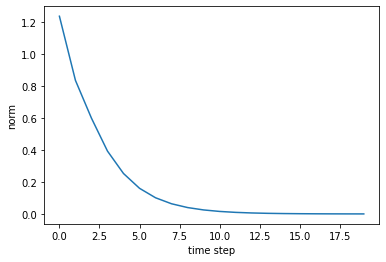

In [5]:
x = np.arange(len(norm_list))
plt.plot(x, norm_list, label='test')
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

指数的に減少していることが確認できる

勾配クリッピングの実装

In [6]:
def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad**2)
  total_norm = np.sqrt(total_norm)

  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate

In [7]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
print(grads)
max_norm = 5.0

clip_grads(grads, max_norm)
print(grads)

[array([[6.49144048, 2.78487283, 6.76254902],
       [5.90862817, 0.23981882, 5.58854088],
       [2.59252447, 4.15101197, 2.83525082]]), array([[6.93137918, 4.40453718, 1.56867738],
       [5.44649018, 7.80314765, 3.06363532],
       [2.21957884, 3.87971258, 9.3638365 ]])]
[array([[1.49503731, 0.64138134, 1.55747605],
       [1.36081038, 0.05523244, 1.28709139],
       [0.59708178, 0.95601551, 0.65298384]]), array([[1.59635916, 1.01440465, 0.36128056],
       [1.25437583, 1.79713531, 0.70558286],
       [0.51118903, 0.89353281, 2.15657603]])]


LSTMクラスの実装

In [1]:
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    c_next = f*c_prev + g*i
    h_next = o*np.tanh(c_next)
    self.cache = o*np.tanh(c_next)
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

TimeLSTMクラスの実装

In [2]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]
    self.layers = []
    hs = np.empty((N, T, H), dtype='f')
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c in None:
      self.c = np.zeros((N, H), dtype='f')

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h
      self.layers.append(layer)
    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]
    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :]+dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
      self.dh = dh
      return dxs
    
  def set_state(self, h, c=None):
    self.h, self.c = h, c
  
  def reset_state(self):
    self.h, self.c = None, None

In [3]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks'
import os
os.chdir(dir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from common.time_layers import *
import pickle

In [5]:
class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.rand

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, H*4)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H, V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.layers = [
        TimeEmbedding(embed_W),
        TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout =  layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.lstm_layer.reset_state()

  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)

  def load_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f) 

学習

In [17]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10340.84
| epoch 1 |  iter 21 / 1327 | time 6[s] | perplexity 288630.76
| epoch 1 |  iter 41 / 1327 | time 13[s] | perplexity 1617.89
| epoch 1 |  iter 61 / 1327 | time 19[s] | perplexity 1138.13
| epoch 1 |  iter 81 / 1327 | time 26[s] | perplexity 960.79
| epoch 1 |  iter 101 / 1327 | time 32[s] | perplexity 770.68
| epoch 1 |  iter 121 / 1327 | time 39[s] | perplexity 813.09
| epoch 1 |  iter 141 / 1327 | time 45[s] | perplexity 748.10
| epoch 1 |  iter 161 / 1327 | time 52[s] | perplexity 707.79
| epoch 1 |  iter 181 / 1327 | time 58[s] | perplexity 705.23
| epoch 1 |  iter 201 / 1327 | time 65[s] | perplexity 629.66
| epoch 1 |  iter 221 / 1327 | time 71[s] | perplexity 618.24
| epoch 1 |  iter 241 / 1327 | time 78[s] | perplexity 555.78
| epoch 1 |  iter 261 / 1327 | time 84[s] | perplexity 600.29
| epoch 1 |  iter 281 / 1327 | time 91[s] | perplexity 582.64
| epoch 1 |  iter 301 / 1327 | time 97[s] | perplexity 494.90
| epoch 1

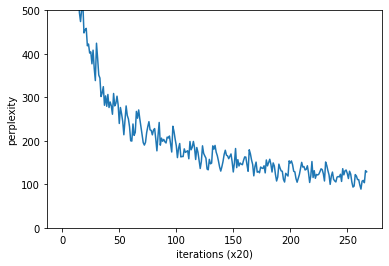

evaluating perplexity ...
234 / 235
test perplexity:  144.78990098811042


In [18]:
#パラメータ設定
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25
#データ読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]
#モデル生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)
#勾配クリッピング適用　学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))
#評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)
#保存
model.save_params()

改良したRnnlmクラスの実装

In [6]:
from common.time_layers import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx1 = (rn(D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.layers = [
        TimeEmbedding(embed_W),
        TimeDropout(dropout_ratio),
        TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
        TimeDropout(dropout_ratio),
        TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
        TimeDropout(dropout_ratio),
        TimeAffine(embed_W.T, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
  def predict(self, xs, train_flg=False):
    for layer in self.drop_layers:
      layer.train_flg = train_flg
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()